# Figure 3H, I

In [1]:
%load_ext nb_black

import scdiffeq as sdq
import pathlib
import matplotlib.pyplot as plt
import cellplots as cp
import ABCParse

print(sdq.__version__, sdq.__path__)

0.1.2rc0 ['/home/mvinyard/github/scDiffEq/scdiffeq']


<IPython.core.display.Javascript object>

### Load data, dimension reduction models

In [2]:
data_dir = pathlib.Path("/home/mvinyard/data/scdiffeq_data/human_hematopoiesis/")
h5ad_path = data_dir.joinpath("human_hematopoiesis.preprocessed.h5ad")
pca_model_path = data_dir.joinpath("human_hematopoiesis.pca_model.pkl")
umap_model_path = data_dir.joinpath("human_hematopoiesis.umap_model.pkl")

adata = sdq.io.read_h5ad(h5ad_path)
pca = sdq.io.read_pickle(pca_model_path)
umap = sdq.io.read_pickle(umap_model_path)

AnnData object with n_obs × n_vars = 1947 × 2477
    obs: 'batch', '_time', 'nGenes', 'UMI', 't', 'n_genes', 'cell_type'
    var: 'gene_name', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'h5ad_path'
    obsm: 'X_pca', 'X_umap'
    layers: 'X_l_TC', 'X_n_TC', 'X_orig', 'ambiguous', 'labeled_TC', 'sl_TC', 'sn_TC', 'spliced', 'total', 'ul_TC', 'un_TC', 'unlabeled_TC', 'unspliced'


<IPython.core.display.Javascript object>

### Define some helper functions

In [3]:
class ManuscriptFigurePlot(ABCParse.ABCParse):
    def __init__(self, cmap=None, color_quantile_cutoff: float = 0.01, *args, **kwargs):

        self.__parse__(locals())

    @property
    def cmap(self):
        if self._cmap is None:
            self._cmap = {
                "HSC": "#023047",
                "MEP-like": "#fb8500",
                "GMP-like": "#126782",
                "Bas": "#219ebc",
                "Mon": "#58b4d1",
                "Neu": "#8ecae6",
                "Meg": "#ffb703",
                "Ery": "#fd9e02",
            }
        return self._cmap

    @property
    def scatter_kwargs(self):
        return {
            "s": 80,
            "ec": "None",
            "alpha": 0.4,
            "vmin": self._adata.obs[self._c].quantile(self._color_quantile_cutoff),
            "vmax": self._adata.obs[self._c].quantile(1 - self._color_quantile_cutoff),
        }

    def plot_manifold(
        self,
        adata,
        groupby: str = "cell_type",
        s_background=350,
        s_cover=200,
        *args,
        **kwargs
    ):
        fig, axes = cp.plot(
            1, 1, height=1, width=1.2, del_xy_ticks=[True], delete="all"
        )
        axes = cp.umap_manifold(
            adata,
            groupby=groupby,
            c_background=self.cmap,
            s_background=s_background,
            s_cover=s_cover,
            ax=axes[0],
            *args,
            **kwargs,
        )

        self.axes = axes
        self.axes[0].legend(
            facecolor="None", edgecolor="None", markerscale=0.4, loc=(1.2, 0)
        )

    def plot_velocity(
        self,
        adata,
        c="diffusion",
        scatter_zorder=101,
        stream_zorder=110,
        return_axes=True,
        png_dpi=500,
        save=True,
        svg_dpi=500,
        scatter_kwargs={},
        *args,
        **kwargs
    ):

        scatter_kw = self.scatter_kwargs.copy()
        scatter_kw.update(scatter_kwargs)

        self.axes[0] = sdq.pl.velocity_stream(
            adata,
            c=c,
            ax=self.axes[0],
            scatter_kwargs=scatter_kw,
            scatter_zorder=scatter_zorder,
            stream_zorder=stream_zorder,
            return_axes=return_axes,
            png_dpi=png_dpi,
            save=save,
            svg_dpi=svg_dpi,
            *args,
            **kwargs,
        )

    def __call__(
        self,
        adata,
        groupby: str = "cell_type",
        s_background=350,
        s_cover=200,
        c="diffusion",
        scatter_zorder=101,
        stream_zorder=110,
        return_axes=True,
        png_dpi=500,
        save=True,
        svg_dpi=500,
        scatter_kwargs={},
        *args,
        **kwargs
    ):
        self.__update__(locals())

        self.plot_manifold(
            adata=adata,
            groupby=groupby,
            s_background=s_background,
            s_cover=s_cover,
        )
        self.plot_velocity(
            adata=adata,
            c=c,
            scatter_zorder=scatter_zorder,
            stream_zorder=stream_zorder,
            return_axes=return_axes,
            png_dpi=png_dpi,
            save=save,
            svg_dpi=svg_dpi,
            scatter_kwargs=scatter_kwargs,
        )
        plt.show()

<IPython.core.display.Javascript object>

### Figure 3H: plot the dataset UMAP manifold

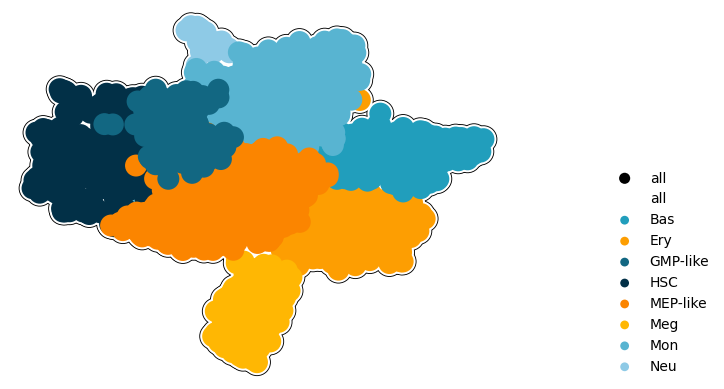

<IPython.core.display.Javascript object>

In [4]:
cmap = {
    "HSC": "#023047",
    "MEP-like": "#fb8500",
    "GMP-like": "#126782",
    "Bas": "#219ebc",
    "Mon": "#58b4d1",
    "Neu": "#8ecae6",
    "Meg": "#ffb703",
    "Ery": "#fd9e02",
}
zorder = {
    "HSC": 105,
    "MEP-like": 106,
    "GMP-like": 107,
    "Bas": 104,
    "Mon": 104,
    "Neu": 103,
    "Meg": 102,
    "Ery": 101,
}
axes = cp.umap_manifold(
    adata, c_background="k", s_background=400, c_cover="white", s_cover=350
)
axes = cp.umap(
    adata, groupby="cell_type", cmap=cmap, s=250, ax=axes[0], force_zorder=zorder
)
axes[0].legend(facecolor="None", edgecolor="None", markerscale=0.4, loc=(1.2, 0))
plt.savefig("human_hematopoiesis.dynamo.svg", dpi=500)

### Load project

This "project" consists of five "versions". In this case, each version is identical, wherein we run model training over five seeds (0 through 4).

In [5]:
project = sdq.io.Project("./LightningSDE-FixedPotential-RegularizedVelocityRatio/")

<IPython.core.display.Javascript object>

### Define helper functions

In [7]:
def aggr(df):
    return df.filter(regex="sinkhorn").filter(regex="validation").dropna().sum(1).mean()


import pandas as pd


def aggr_total_loss(group_df, key="training"):

    SD_loss = group_df.filter(regex="sinkhorn").filter(regex=key).dropna().sum(1).mean()

    VR_loss = (
        group_df.filter(regex="velo_ratio").filter(regex=key).dropna().sum(1).mean()
    )
    total_loss = VR_loss + SD_loss
    return pd.Series({"total": total_loss, "VR": VR_loss, "SD": SD_loss})


def get_best_saved_ckpt(version):
    grouped = version.metrics_df.groupby("epoch")
    val = grouped.apply(aggr_total_loss)
    saved_ckpts = list(version.ckpts.keys())
    saved_ckpts.remove("last")
    saved_ckpts.append(2499)
    best_epoch = val["total"].loc[saved_ckpts].idxmin()
    return best_epoch

<IPython.core.display.Javascript object>

## Figure 3I: scDiffEq velocity stream plots: human hematopoiesis

Seed set to 0


 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']
 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Added: adata.obsp['distances']
 - [INFO] | Added: adata.obsp['connectivities']
 - [INFO] | Added: adata.uns['neighbors']
 - [INFO] | Added: adata.obsp['velocity_graph']
 - [INFO] | Added: adata.obsp['velocity_graph_neg']
 - [INFO] | Saved to: 
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_1.epoch_1446.svg
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_1.epoch_1446.png


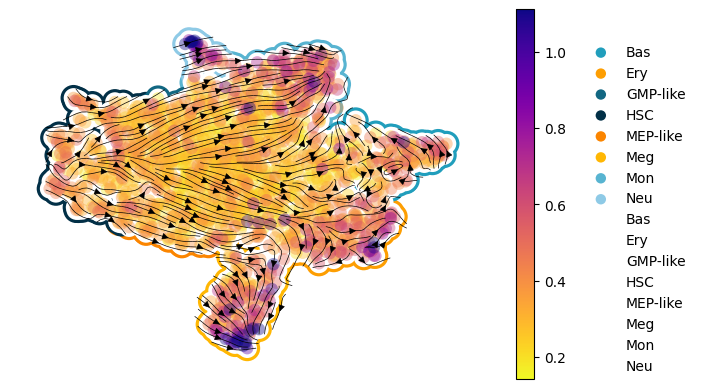

Seed set to 0


 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']
 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Updated: adata.obsp['velocity_graph']
 - [INFO] | Updated: adata.obsp['velocity_graph_neg']
 - [INFO] | Saved to: 
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_2.epoch_1464.svg
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_2.epoch_1464.png


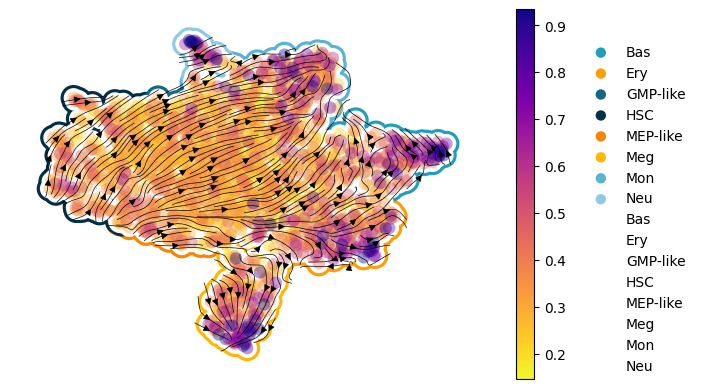

Seed set to 0


 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']
 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Updated: adata.obsp['velocity_graph']
 - [INFO] | Updated: adata.obsp['velocity_graph_neg']
 - [INFO] | Saved to: 
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_3.epoch_1543.svg
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_3.epoch_1543.png


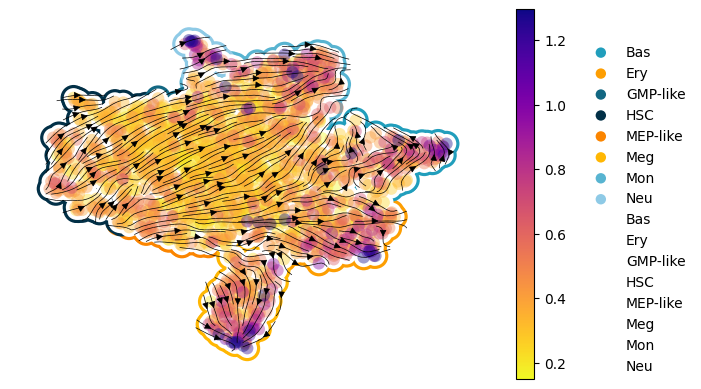

Seed set to 0


 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']
 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Updated: adata.obsp['velocity_graph']
 - [INFO] | Updated: adata.obsp['velocity_graph_neg']
 - [INFO] | Saved to: 
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_4.epoch_1951.svg
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_4.epoch_1951.png


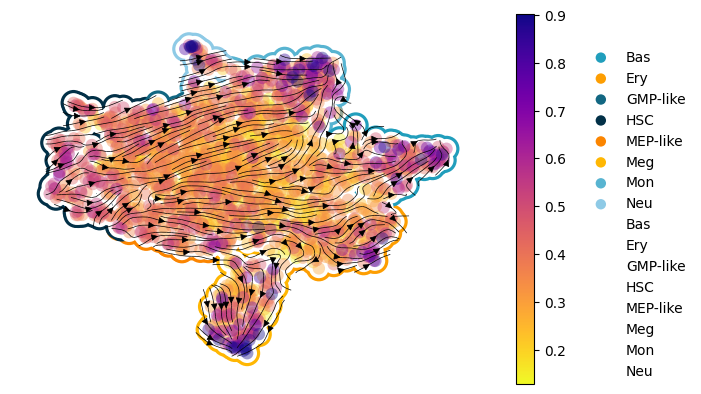

Seed set to 0


 - [INFO] | Input data configured.
 - [INFO] | Bulding Annoy kNN Graph on adata.obsm['train']
 - [INFO] | Using the specified parameters, LightningSDE-FixedPotential-RegularizedVelocityRatio has been called.
 - [INFO] | Updated: adata.obsp['velocity_graph']
 - [INFO] | Updated: adata.obsp['velocity_graph_neg']
 - [INFO] | Saved to: 
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_5.epoch_2264.svg
  scdiffeq_figures/velocity_stream.human_hematopoiesis.version_5.epoch_2264.png


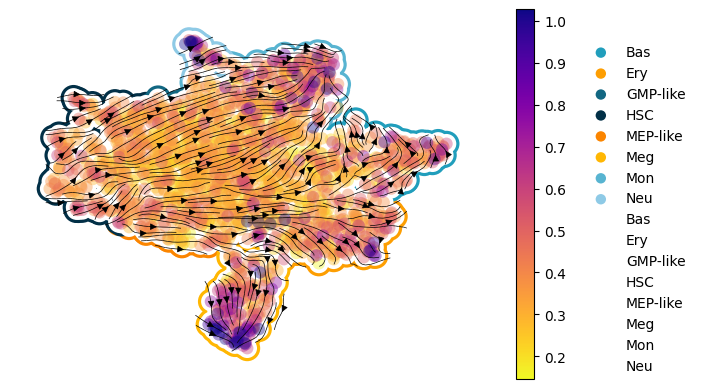

<IPython.core.display.Javascript object>

In [8]:
for v, version_path in project._VERSION_PATHS.items():
    version = sdq.io.Version(version_path)
    best_ckpt_epoch = get_best_saved_ckpt(version)
    ckpt_path = version.ckpts[best_ckpt_epoch].path
    model = sdq.io.load_model(adata=adata, ckpt_path=ckpt_path)
    adata.uns["sdq_info"] = (
        f"human_hematopoiesis.{v}.epoch_{best_ckpt_epoch}"  # used for saving plot to a unique fname
    )
    model.drift(adata, silent=True)
    model.diffusion(adata, silent=True)
    sdq.tl.velocity_graph(adata, n_pcs=10)
    plot = ManuscriptFigurePlot()
    plot(adata)